In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Dense, Bidirectional, LSTM, SimpleRNN, Dropout, TimeDistributed, Layer, Input, Concatenate, GlobalAveragePooling1D, Conv1D, LayerNormalization
from sklearn.metrics import *
from keras.optimizers import Adam
import keras.backend as K
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow_addons.layers import MultiHeadAttention
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
dataset = pd.read_csv('dati_continui_con_id.csv')
# creo una lista di di dataframe dove ogni elemento è l'insieme delle date per utente
utenti = []
# carico elenco utenti per scorrere tutti gli id
elenco_utenti = pd.read_csv('../dataset/userinfo.csv')
elenco_utenti.drop(elenco_utenti.columns[[0, 3]], axis=1, inplace=True)
elenco_utenti.columns = ['user_id', 'timezone', 'sex', 'age', 'height']
elenco_utenti.head()
dataset.set_index(['user_id','date'], inplace=True)
# inserisco per ogni elemento della lista il dataframe relativo ad un utente presente nel dataset
for i, r in elenco_utenti.iterrows():
    utente = r['user_id']
    if utente in dataset.index:
        utenti.append(dataset.loc[utente])
# elimina stagionalitò
senza_stag = []
stato = 0
for corrente in utenti:
    print(str(stato) + " / 15971")
    stato = stato+1;
    if len(corrente) >=14:
        lista_stag = []
        lista_stag.append(corrente[['steps']].squeeze() - seasonal_decompose(corrente[['steps']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['bedin']].squeeze() - seasonal_decompose(corrente[['bedin']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['bedout']].squeeze() - seasonal_decompose(corrente[['bedout']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['sleep duration']].squeeze() - seasonal_decompose(corrente[['sleep duration']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['deepduration']].squeeze()  - seasonal_decompose(corrente[['sleep duration']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['lightduration']].squeeze() - seasonal_decompose(corrente[['sleep duration']], model='additive', period = 7).seasonal)
        frame = {'steps' : lista_stag[0], 'bedin' : lista_stag[1], 'bedout' : lista_stag[2], 'sleep duration' : lista_stag[3], 'deepduration' : lista_stag[4], 'lightduration' : lista_stag[5]}
        senza_stag.append(pd.DataFrame(frame))
utenti = senza_stag
# Funzione normalizzazione
scaler = MinMaxScaler(feature_range=(0,1))
def normalizza(dat):
    df_for_training_scaled = scaler.fit_transform(dat)
    return df_for_training_scaled
# Adesso normalizza ogni dataset
utenti_normalizzati = []
for u in utenti:
    utenti_normalizzati.append(normalizza(u))
#n_past is the number of step we will look in the past to predict the next target value.
col2pred = 4  # 0:steps, 1:bedin, 2:bedout, 3:sleep duration, 4:deep duration, 5:lightduration
window_size = 7
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #per ogni feature fa l'append dei precedenti
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])  
            dataY.append(dataset[i,col2pred])
    return np.array(dataX),np.array(dataY)
# crea insieme di train
train_lista = utenti_normalizzati[:7000]

trainX_lista = []
trainY_lista = []

for t in train_lista:
    trainX_temp, trainY_temp = createXY(t,window_size)
    if len(trainX_temp.shape) == 3 and len(trainY_temp.shape) == 1:
        trainX_lista.append(trainX_temp)
        trainY_lista.append(trainY_temp)

trainX = np.concatenate(trainX_lista)
trainY = np.concatenate(trainY_lista)
# crea insieme di test
test_lista = utenti_normalizzati[7000:]

testX_lista = []
testY_lista = []

for t in test_lista:
    testX_temp, testY_temp = createXY(t,window_size)
    if len(testX_temp.shape) == 3 and len(testY_temp.shape) == 1:
        testX_lista.append(testX_temp)
        testY_lista.append(testY_temp)

testX = np.concatenate(testX_lista)
testY = np.concatenate(testY_lista)
# features num
features_num = dataset.shape[1]

0 / 15971
1 / 15971
2 / 15971
3 / 15971
4 / 15971
5 / 15971
6 / 15971
7 / 15971
8 / 15971
9 / 15971
10 / 15971
11 / 15971
12 / 15971
13 / 15971
14 / 15971
15 / 15971
16 / 15971
17 / 15971
18 / 15971
19 / 15971
20 / 15971
21 / 15971
22 / 15971
23 / 15971
24 / 15971
25 / 15971
26 / 15971
27 / 15971
28 / 15971
29 / 15971
30 / 15971
31 / 15971
32 / 15971
33 / 15971
34 / 15971
35 / 15971
36 / 15971
37 / 15971
38 / 15971
39 / 15971
40 / 15971
41 / 15971
42 / 15971
43 / 15971
44 / 15971
45 / 15971
46 / 15971
47 / 15971
48 / 15971
49 / 15971
50 / 15971
51 / 15971
52 / 15971
53 / 15971
54 / 15971
55 / 15971
56 / 15971
57 / 15971
58 / 15971
59 / 15971
60 / 15971
61 / 15971
62 / 15971
63 / 15971
64 / 15971
65 / 15971
66 / 15971
67 / 15971
68 / 15971
69 / 15971
70 / 15971
71 / 15971
72 / 15971
73 / 15971
74 / 15971
75 / 15971
76 / 15971
77 / 15971
78 / 15971
79 / 15971
80 / 15971
81 / 15971
82 / 15971
83 / 15971
84 / 15971
85 / 15971
86 / 15971
87 / 15971
88 / 15971
89 / 15971
90 / 15971
91 / 1597

713 / 15971
714 / 15971
715 / 15971
716 / 15971
717 / 15971
718 / 15971
719 / 15971
720 / 15971
721 / 15971
722 / 15971
723 / 15971
724 / 15971
725 / 15971
726 / 15971
727 / 15971
728 / 15971
729 / 15971
730 / 15971
731 / 15971
732 / 15971
733 / 15971
734 / 15971
735 / 15971
736 / 15971
737 / 15971
738 / 15971
739 / 15971
740 / 15971
741 / 15971
742 / 15971
743 / 15971
744 / 15971
745 / 15971
746 / 15971
747 / 15971
748 / 15971
749 / 15971
750 / 15971
751 / 15971
752 / 15971
753 / 15971
754 / 15971
755 / 15971
756 / 15971
757 / 15971
758 / 15971
759 / 15971
760 / 15971
761 / 15971
762 / 15971
763 / 15971
764 / 15971
765 / 15971
766 / 15971
767 / 15971
768 / 15971
769 / 15971
770 / 15971
771 / 15971
772 / 15971
773 / 15971
774 / 15971
775 / 15971
776 / 15971
777 / 15971
778 / 15971
779 / 15971
780 / 15971
781 / 15971
782 / 15971
783 / 15971
784 / 15971
785 / 15971
786 / 15971
787 / 15971
788 / 15971
789 / 15971
790 / 15971
791 / 15971
792 / 15971
793 / 15971
794 / 15971
795 / 15971
796 

1377 / 15971
1378 / 15971
1379 / 15971
1380 / 15971
1381 / 15971
1382 / 15971
1383 / 15971
1384 / 15971
1385 / 15971
1386 / 15971
1387 / 15971
1388 / 15971
1389 / 15971
1390 / 15971
1391 / 15971
1392 / 15971
1393 / 15971
1394 / 15971
1395 / 15971
1396 / 15971
1397 / 15971
1398 / 15971
1399 / 15971
1400 / 15971
1401 / 15971
1402 / 15971
1403 / 15971
1404 / 15971
1405 / 15971
1406 / 15971
1407 / 15971
1408 / 15971
1409 / 15971
1410 / 15971
1411 / 15971
1412 / 15971
1413 / 15971
1414 / 15971
1415 / 15971
1416 / 15971
1417 / 15971
1418 / 15971
1419 / 15971
1420 / 15971
1421 / 15971
1422 / 15971
1423 / 15971
1424 / 15971
1425 / 15971
1426 / 15971
1427 / 15971
1428 / 15971
1429 / 15971
1430 / 15971
1431 / 15971
1432 / 15971
1433 / 15971
1434 / 15971
1435 / 15971
1436 / 15971
1437 / 15971
1438 / 15971
1439 / 15971
1440 / 15971
1441 / 15971
1442 / 15971
1443 / 15971
1444 / 15971
1445 / 15971
1446 / 15971
1447 / 15971
1448 / 15971
1449 / 15971
1450 / 15971
1451 / 15971
1452 / 15971
1453 / 15971

2009 / 15971
2010 / 15971
2011 / 15971
2012 / 15971
2013 / 15971
2014 / 15971
2015 / 15971
2016 / 15971
2017 / 15971
2018 / 15971
2019 / 15971
2020 / 15971
2021 / 15971
2022 / 15971
2023 / 15971
2024 / 15971
2025 / 15971
2026 / 15971
2027 / 15971
2028 / 15971
2029 / 15971
2030 / 15971
2031 / 15971
2032 / 15971
2033 / 15971
2034 / 15971
2035 / 15971
2036 / 15971
2037 / 15971
2038 / 15971
2039 / 15971
2040 / 15971
2041 / 15971
2042 / 15971
2043 / 15971
2044 / 15971
2045 / 15971
2046 / 15971
2047 / 15971
2048 / 15971
2049 / 15971
2050 / 15971
2051 / 15971
2052 / 15971
2053 / 15971
2054 / 15971
2055 / 15971
2056 / 15971
2057 / 15971
2058 / 15971
2059 / 15971
2060 / 15971
2061 / 15971
2062 / 15971
2063 / 15971
2064 / 15971
2065 / 15971
2066 / 15971
2067 / 15971
2068 / 15971
2069 / 15971
2070 / 15971
2071 / 15971
2072 / 15971
2073 / 15971
2074 / 15971
2075 / 15971
2076 / 15971
2077 / 15971
2078 / 15971
2079 / 15971
2080 / 15971
2081 / 15971
2082 / 15971
2083 / 15971
2084 / 15971
2085 / 15971

2660 / 15971
2661 / 15971
2662 / 15971
2663 / 15971
2664 / 15971
2665 / 15971
2666 / 15971
2667 / 15971
2668 / 15971
2669 / 15971
2670 / 15971
2671 / 15971
2672 / 15971
2673 / 15971
2674 / 15971
2675 / 15971
2676 / 15971
2677 / 15971
2678 / 15971
2679 / 15971
2680 / 15971
2681 / 15971
2682 / 15971
2683 / 15971
2684 / 15971
2685 / 15971
2686 / 15971
2687 / 15971
2688 / 15971
2689 / 15971
2690 / 15971
2691 / 15971
2692 / 15971
2693 / 15971
2694 / 15971
2695 / 15971
2696 / 15971
2697 / 15971
2698 / 15971
2699 / 15971
2700 / 15971
2701 / 15971
2702 / 15971
2703 / 15971
2704 / 15971
2705 / 15971
2706 / 15971
2707 / 15971
2708 / 15971
2709 / 15971
2710 / 15971
2711 / 15971
2712 / 15971
2713 / 15971
2714 / 15971
2715 / 15971
2716 / 15971
2717 / 15971
2718 / 15971
2719 / 15971
2720 / 15971
2721 / 15971
2722 / 15971
2723 / 15971
2724 / 15971
2725 / 15971
2726 / 15971
2727 / 15971
2728 / 15971
2729 / 15971
2730 / 15971
2731 / 15971
2732 / 15971
2733 / 15971
2734 / 15971
2735 / 15971
2736 / 15971

3305 / 15971
3306 / 15971
3307 / 15971
3308 / 15971
3309 / 15971
3310 / 15971
3311 / 15971
3312 / 15971
3313 / 15971
3314 / 15971
3315 / 15971
3316 / 15971
3317 / 15971
3318 / 15971
3319 / 15971
3320 / 15971
3321 / 15971
3322 / 15971
3323 / 15971
3324 / 15971
3325 / 15971
3326 / 15971
3327 / 15971
3328 / 15971
3329 / 15971
3330 / 15971
3331 / 15971
3332 / 15971
3333 / 15971
3334 / 15971
3335 / 15971
3336 / 15971
3337 / 15971
3338 / 15971
3339 / 15971
3340 / 15971
3341 / 15971
3342 / 15971
3343 / 15971
3344 / 15971
3345 / 15971
3346 / 15971
3347 / 15971
3348 / 15971
3349 / 15971
3350 / 15971
3351 / 15971
3352 / 15971
3353 / 15971
3354 / 15971
3355 / 15971
3356 / 15971
3357 / 15971
3358 / 15971
3359 / 15971
3360 / 15971
3361 / 15971
3362 / 15971
3363 / 15971
3364 / 15971
3365 / 15971
3366 / 15971
3367 / 15971
3368 / 15971
3369 / 15971
3370 / 15971
3371 / 15971
3372 / 15971
3373 / 15971
3374 / 15971
3375 / 15971
3376 / 15971
3377 / 15971
3378 / 15971
3379 / 15971
3380 / 15971
3381 / 15971

3936 / 15971
3937 / 15971
3938 / 15971
3939 / 15971
3940 / 15971
3941 / 15971
3942 / 15971
3943 / 15971
3944 / 15971
3945 / 15971
3946 / 15971
3947 / 15971
3948 / 15971
3949 / 15971
3950 / 15971
3951 / 15971
3952 / 15971
3953 / 15971
3954 / 15971
3955 / 15971
3956 / 15971
3957 / 15971
3958 / 15971
3959 / 15971
3960 / 15971
3961 / 15971
3962 / 15971
3963 / 15971
3964 / 15971
3965 / 15971
3966 / 15971
3967 / 15971
3968 / 15971
3969 / 15971
3970 / 15971
3971 / 15971
3972 / 15971
3973 / 15971
3974 / 15971
3975 / 15971
3976 / 15971
3977 / 15971
3978 / 15971
3979 / 15971
3980 / 15971
3981 / 15971
3982 / 15971
3983 / 15971
3984 / 15971
3985 / 15971
3986 / 15971
3987 / 15971
3988 / 15971
3989 / 15971
3990 / 15971
3991 / 15971
3992 / 15971
3993 / 15971
3994 / 15971
3995 / 15971
3996 / 15971
3997 / 15971
3998 / 15971
3999 / 15971
4000 / 15971
4001 / 15971
4002 / 15971
4003 / 15971
4004 / 15971
4005 / 15971
4006 / 15971
4007 / 15971
4008 / 15971
4009 / 15971
4010 / 15971
4011 / 15971
4012 / 15971

4584 / 15971
4585 / 15971
4586 / 15971
4587 / 15971
4588 / 15971
4589 / 15971
4590 / 15971
4591 / 15971
4592 / 15971
4593 / 15971
4594 / 15971
4595 / 15971
4596 / 15971
4597 / 15971
4598 / 15971
4599 / 15971
4600 / 15971
4601 / 15971
4602 / 15971
4603 / 15971
4604 / 15971
4605 / 15971
4606 / 15971
4607 / 15971
4608 / 15971
4609 / 15971
4610 / 15971
4611 / 15971
4612 / 15971
4613 / 15971
4614 / 15971
4615 / 15971
4616 / 15971
4617 / 15971
4618 / 15971
4619 / 15971
4620 / 15971
4621 / 15971
4622 / 15971
4623 / 15971
4624 / 15971
4625 / 15971
4626 / 15971
4627 / 15971
4628 / 15971
4629 / 15971
4630 / 15971
4631 / 15971
4632 / 15971
4633 / 15971
4634 / 15971
4635 / 15971
4636 / 15971
4637 / 15971
4638 / 15971
4639 / 15971
4640 / 15971
4641 / 15971
4642 / 15971
4643 / 15971
4644 / 15971
4645 / 15971
4646 / 15971
4647 / 15971
4648 / 15971
4649 / 15971
4650 / 15971
4651 / 15971
4652 / 15971
4653 / 15971
4654 / 15971
4655 / 15971
4656 / 15971
4657 / 15971
4658 / 15971
4659 / 15971
4660 / 15971

5220 / 15971
5221 / 15971
5222 / 15971
5223 / 15971
5224 / 15971
5225 / 15971
5226 / 15971
5227 / 15971
5228 / 15971
5229 / 15971
5230 / 15971
5231 / 15971
5232 / 15971
5233 / 15971
5234 / 15971
5235 / 15971
5236 / 15971
5237 / 15971
5238 / 15971
5239 / 15971
5240 / 15971
5241 / 15971
5242 / 15971
5243 / 15971
5244 / 15971
5245 / 15971
5246 / 15971
5247 / 15971
5248 / 15971
5249 / 15971
5250 / 15971
5251 / 15971
5252 / 15971
5253 / 15971
5254 / 15971
5255 / 15971
5256 / 15971
5257 / 15971
5258 / 15971
5259 / 15971
5260 / 15971
5261 / 15971
5262 / 15971
5263 / 15971
5264 / 15971
5265 / 15971
5266 / 15971
5267 / 15971
5268 / 15971
5269 / 15971
5270 / 15971
5271 / 15971
5272 / 15971
5273 / 15971
5274 / 15971
5275 / 15971
5276 / 15971
5277 / 15971
5278 / 15971
5279 / 15971
5280 / 15971
5281 / 15971
5282 / 15971
5283 / 15971
5284 / 15971
5285 / 15971
5286 / 15971
5287 / 15971
5288 / 15971
5289 / 15971
5290 / 15971
5291 / 15971
5292 / 15971
5293 / 15971
5294 / 15971
5295 / 15971
5296 / 15971

5851 / 15971
5852 / 15971
5853 / 15971
5854 / 15971
5855 / 15971
5856 / 15971
5857 / 15971
5858 / 15971
5859 / 15971
5860 / 15971
5861 / 15971
5862 / 15971
5863 / 15971
5864 / 15971
5865 / 15971
5866 / 15971
5867 / 15971
5868 / 15971
5869 / 15971
5870 / 15971
5871 / 15971
5872 / 15971
5873 / 15971
5874 / 15971
5875 / 15971
5876 / 15971
5877 / 15971
5878 / 15971
5879 / 15971
5880 / 15971
5881 / 15971
5882 / 15971
5883 / 15971
5884 / 15971
5885 / 15971
5886 / 15971
5887 / 15971
5888 / 15971
5889 / 15971
5890 / 15971
5891 / 15971
5892 / 15971
5893 / 15971
5894 / 15971
5895 / 15971
5896 / 15971
5897 / 15971
5898 / 15971
5899 / 15971
5900 / 15971
5901 / 15971
5902 / 15971
5903 / 15971
5904 / 15971
5905 / 15971
5906 / 15971
5907 / 15971
5908 / 15971
5909 / 15971
5910 / 15971
5911 / 15971
5912 / 15971
5913 / 15971
5914 / 15971
5915 / 15971
5916 / 15971
5917 / 15971
5918 / 15971
5919 / 15971
5920 / 15971
5921 / 15971
5922 / 15971
5923 / 15971
5924 / 15971
5925 / 15971
5926 / 15971
5927 / 15971

6484 / 15971
6485 / 15971
6486 / 15971
6487 / 15971
6488 / 15971
6489 / 15971
6490 / 15971
6491 / 15971
6492 / 15971
6493 / 15971
6494 / 15971
6495 / 15971
6496 / 15971
6497 / 15971
6498 / 15971
6499 / 15971
6500 / 15971
6501 / 15971
6502 / 15971
6503 / 15971
6504 / 15971
6505 / 15971
6506 / 15971
6507 / 15971
6508 / 15971
6509 / 15971
6510 / 15971
6511 / 15971
6512 / 15971
6513 / 15971
6514 / 15971
6515 / 15971
6516 / 15971
6517 / 15971
6518 / 15971
6519 / 15971
6520 / 15971
6521 / 15971
6522 / 15971
6523 / 15971
6524 / 15971
6525 / 15971
6526 / 15971
6527 / 15971
6528 / 15971
6529 / 15971
6530 / 15971
6531 / 15971
6532 / 15971
6533 / 15971
6534 / 15971
6535 / 15971
6536 / 15971
6537 / 15971
6538 / 15971
6539 / 15971
6540 / 15971
6541 / 15971
6542 / 15971
6543 / 15971
6544 / 15971
6545 / 15971
6546 / 15971
6547 / 15971
6548 / 15971
6549 / 15971
6550 / 15971
6551 / 15971
6552 / 15971
6553 / 15971
6554 / 15971
6555 / 15971
6556 / 15971
6557 / 15971
6558 / 15971
6559 / 15971
6560 / 15971

7117 / 15971
7118 / 15971
7119 / 15971
7120 / 15971
7121 / 15971
7122 / 15971
7123 / 15971
7124 / 15971
7125 / 15971
7126 / 15971
7127 / 15971
7128 / 15971
7129 / 15971
7130 / 15971
7131 / 15971
7132 / 15971
7133 / 15971
7134 / 15971
7135 / 15971
7136 / 15971
7137 / 15971
7138 / 15971
7139 / 15971
7140 / 15971
7141 / 15971
7142 / 15971
7143 / 15971
7144 / 15971
7145 / 15971
7146 / 15971
7147 / 15971
7148 / 15971
7149 / 15971
7150 / 15971
7151 / 15971
7152 / 15971
7153 / 15971
7154 / 15971
7155 / 15971
7156 / 15971
7157 / 15971
7158 / 15971
7159 / 15971
7160 / 15971
7161 / 15971
7162 / 15971
7163 / 15971
7164 / 15971
7165 / 15971
7166 / 15971
7167 / 15971
7168 / 15971
7169 / 15971
7170 / 15971
7171 / 15971
7172 / 15971
7173 / 15971
7174 / 15971
7175 / 15971
7176 / 15971
7177 / 15971
7178 / 15971
7179 / 15971
7180 / 15971
7181 / 15971
7182 / 15971
7183 / 15971
7184 / 15971
7185 / 15971
7186 / 15971
7187 / 15971
7188 / 15971
7189 / 15971
7190 / 15971
7191 / 15971
7192 / 15971
7193 / 15971

7757 / 15971
7758 / 15971
7759 / 15971
7760 / 15971
7761 / 15971
7762 / 15971
7763 / 15971
7764 / 15971
7765 / 15971
7766 / 15971
7767 / 15971
7768 / 15971
7769 / 15971
7770 / 15971
7771 / 15971
7772 / 15971
7773 / 15971
7774 / 15971
7775 / 15971
7776 / 15971
7777 / 15971
7778 / 15971
7779 / 15971
7780 / 15971
7781 / 15971
7782 / 15971
7783 / 15971
7784 / 15971
7785 / 15971
7786 / 15971
7787 / 15971
7788 / 15971
7789 / 15971
7790 / 15971
7791 / 15971
7792 / 15971
7793 / 15971
7794 / 15971
7795 / 15971
7796 / 15971
7797 / 15971
7798 / 15971
7799 / 15971
7800 / 15971
7801 / 15971
7802 / 15971
7803 / 15971
7804 / 15971
7805 / 15971
7806 / 15971
7807 / 15971
7808 / 15971
7809 / 15971
7810 / 15971
7811 / 15971
7812 / 15971
7813 / 15971
7814 / 15971
7815 / 15971
7816 / 15971
7817 / 15971
7818 / 15971
7819 / 15971
7820 / 15971
7821 / 15971
7822 / 15971
7823 / 15971
7824 / 15971
7825 / 15971
7826 / 15971
7827 / 15971
7828 / 15971
7829 / 15971
7830 / 15971
7831 / 15971
7832 / 15971
7833 / 15971

In [98]:
class Time2Vec(Layer):

    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)

    def call(self, x):

        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)

        return K.concatenate([sin_trans, original], -1)

In [106]:
def create_t2v_bilstm():
    inp = Input(shape=(window_size, features_num))
    x = Time2Vec(120)(inp)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(256, activation='tanh')(x)
    x = Dense(128, activation='tanh')(x)
    x = Dense(64, activation='tanh')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    opt = Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()

    return model

In [107]:
model = create_t2v_bilstm()

ValueError: Exception encountered when calling layer "Time2VecLayer" (type Time2Vec).

in user code:

    File "<ipython-input-98-4b787420f7a5>", line 16, in call  *
        bias = self.wb * inputs + self.bb

    ValueError: Dimensions must be equal, but are 7 and 6 for '{{node Time2VecLayer/mul}} = Mul[T=DT_FLOAT](Time2VecLayer/ReadVariableOp, Placeholder)' with input shapes: [7], [?,7,6].


Call arguments received by layer "Time2VecLayer" (type Time2Vec):
  • inputs=tf.Tensor(shape=(None, 7, 6), dtype=float32)
  • kwargs={'training': 'False'}

In [8]:
history = model.fit(trainX, trainY, epochs = 50, verbose = 1, batch_size = 4096)

Epoch 1/50
216/216 [==============================] - 14s 31ms/step - loss: 0.0411
Epoch 2/50
216/216 [==============================] - 6s 29ms/step - loss: 0.0357
Epoch 3/50
216/216 [==============================] - 6s 30ms/step - loss: 0.0344
Epoch 4/50
216/216 [==============================] - 7s 30ms/step - loss: 0.0339
Epoch 5/50
216/216 [==============================] - 7s 33ms/step - loss: 0.0335
Epoch 6/50
216/216 [==============================] - 7s 33ms/step - loss: 0.0331
Epoch 7/50
216/216 [==============================] - 7s 34ms/step - loss: 0.0329
Epoch 8/50
216/216 [==============================] - 7s 33ms/step - loss: 0.0326
Epoch 9/50
216/216 [==============================] - 7s 33ms/step - loss: 0.0324
Epoch 10/50
216/216 [==============================] - 7s 31ms/step - loss: 0.0322
Epoch 11/50
216/216 [==============================] - 6s 28ms/step - loss: 0.0321
Epoch 12/50
216/216 [==============================] - 6s 28ms/step - loss: 0.0320
Epoch 13/50


In [9]:
prediction_train = model.predict(trainX)
print("prediction\n", prediction_train)
print("\nPrediction Shape-", prediction_train.shape)

prediction_train_copies_array = np.repeat(prediction_train, features_num, axis=-1)
pred_train = scaler.inverse_transform(np.reshape(prediction_train_copies_array, (len(prediction_train), features_num)))[:, col2pred]
true_value_train_copies_array = np.repeat(trainY, features_num, axis=-1)
true_value_train = scaler.inverse_transform(np.reshape(true_value_train_copies_array, (len(trainY), features_num)))[:, col2pred]

prediction_test=model.predict(testX)
print("prediction\n", prediction_test)
print("\nPrediction Shape-",prediction_test.shape)

prediction_copies_test_array = np.repeat(prediction_test,features_num, axis=-1)
pred_test=scaler.inverse_transform(np.reshape(prediction_copies_test_array,(len(prediction_test),features_num)))[:,col2pred]
true_value_test_copies_array = np.repeat(testY,features_num, axis=-1)
true_value_test=scaler.inverse_transform(np.reshape(true_value_test_copies_array,(len(testY),features_num)))[:,col2pred]

27621/27621 [==============================] - 113s 4ms/step
prediction
 [[0.6215204 ]
 [0.56335187]
 [0.5648811 ]
 ...
 [0.37069613]
 [0.25485265]
 [0.32112408]]

Prediction Shape- (883858, 1)
1189/1189 [==============================] - 5s 4ms/step
prediction
 [[0.5776581 ]
 [0.61028814]
 [0.5828746 ]
 ...
 [0.54843134]
 [0.48251492]
 [0.53830385]]

Prediction Shape- (38017, 1)


In [10]:
def metrics(true_value_train, pred_value_train, true_value_test, pred_value_test):
    print("**********TRAIN-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_train, pred_value_train)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train, squared=True)))
    # metrics test set
    print("**********TEST-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_test, pred_value_test)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test, squared=True)))
    

    plt.plot(true_value_test[:150], color='red', label='Real sleep duration')
    plt.plot(pred_value_test[:150], color='blue', label='Predicted sleep duration')
    plt.title('sleep duration Prediction')
    plt.xlabel('Time')
    plt.ylabel('steps')
    plt.legend()
    plt.show()

**********TRAIN-SET***********
MAE: 0.490
MSE: 0.392
RMSE: 0.392
**********TEST-SET***********
MAE: 0.489
MSE: 0.389
RMSE: 0.389


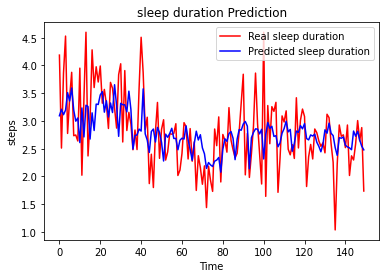

In [11]:
metrics(true_value_train, pred_train, true_value_test, pred_test)

In [120]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [121]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="tanh")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [124]:
input_shape = trainX.shape[1:]

model_t = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_t.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)
model_t.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 7, 6)]       0           []                               
                                                                                                  
 layer_normalization_72 (LayerN  (None, 7, 6)        12          ['input_17[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_37 (Multi  (None, 7, 6)        27654       ['layer_normalization_72[0][0]', 
 HeadAttention)                                                   'layer_normalization_72[0][0]'] 
                                                                                            

 ambda)                                                           'tf.__operators__.add_37[0][0]']
                                                                                                  
 layer_normalization_79 (LayerN  (None, 7, 6)        12          ['tf.__operators__.add_38[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv1d_44 (Conv1D)             (None, 7, 4)         28          ['layer_normalization_79[0][0]'] 
                                                                                                  
 dropout_90 (Dropout)           (None, 7, 4)         0           ['conv1d_44[0][0]']              
                                                                                                  
 conv1d_45 (Conv1D)             (None, 7, 6)         30          ['dropout_90[0][0]']             
          

In [126]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_t.fit(trainX, trainY, epochs = 10, verbose = 1, batch_size = 4096)

Epoch 1/10
216/216 [==============================] - 39s 179ms/step - loss: 0.0537
Epoch 2/10
216/216 [==============================] - 38s 178ms/step - loss: 0.0485
Epoch 3/10
216/216 [==============================] - 39s 180ms/step - loss: 0.0457
Epoch 4/10
216/216 [==============================] - 39s 183ms/step - loss: 0.0445
Epoch 5/10
216/216 [==============================] - 42s 194ms/step - loss: 0.0438
Epoch 6/10
216/216 [==============================] - 39s 182ms/step - loss: 0.0432
Epoch 7/10
216/216 [==============================] - 39s 180ms/step - loss: 0.0427
Epoch 8/10
216/216 [==============================] - 39s 179ms/step - loss: 0.0423
Epoch 9/10
216/216 [==============================] - 38s 178ms/step - loss: 0.0420
Epoch 10/10
216/216 [==============================] - 38s 178ms/step - loss: 0.0417


In [127]:
prediction_train = model_t.predict(trainX)
print("prediction\n", prediction_train)
print("\nPrediction Shape-", prediction_train.shape)

prediction_train_copies_array = np.repeat(prediction_train, features_num, axis=-1)
pred_train = scaler.inverse_transform(np.reshape(prediction_train_copies_array, (len(prediction_train), features_num)))[:, col2pred]
true_value_train_copies_array = np.repeat(trainY, features_num, axis=-1)
true_value_train = scaler.inverse_transform(np.reshape(true_value_train_copies_array, (len(trainY), features_num)))[:, col2pred]

prediction_test=model_t.predict(testX)
print("prediction\n", prediction_test)
print("\nPrediction Shape-",prediction_test.shape)

prediction_copies_test_array = np.repeat(prediction_test,features_num, axis=-1)
pred_test=scaler.inverse_transform(np.reshape(prediction_copies_test_array,(len(prediction_test),features_num)))[:,col2pred]
true_value_test_copies_array = np.repeat(testY,features_num, axis=-1)
true_value_test=scaler.inverse_transform(np.reshape(true_value_test_copies_array,(len(testY),features_num)))[:,col2pred]

27621/27621 [==============================] - 176s 6ms/step
prediction
 [[0.44660062]
 [0.44032004]
 [0.43902886]
 ...
 [0.42479402]
 [0.40666807]
 [0.42329407]]

Prediction Shape- (883858, 1)
1189/1189 [==============================] - 8s 7ms/step
prediction
 [[0.48168677]
 [0.47033665]
 [0.47213286]
 ...
 [0.4443335 ]
 [0.447669  ]
 [0.45670596]]

Prediction Shape- (38017, 1)


**********TRAIN-SET***********
MAE: 0.545
MSE: 0.468
RMSE: 0.468
**********TEST-SET***********
MAE: 0.534
MSE: 0.450
RMSE: 0.450


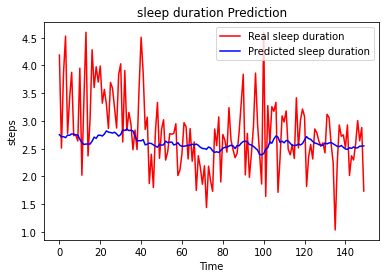

In [128]:
metrics(true_value_train, pred_train, true_value_test, pred_test)

In [ ]:
model_t.evaluate(trainX, trainY, verbose=1)